Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

In [ ]:
from torchvision.datasets import CIFAR10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from PIL import Image
import torch
import torchvision.transforms as transforms

In [ ]:
train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./datasets', train=True, download=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=64, shuffle=False, pin_memory=True)


Files already downloaded and verified


In [ ]:
batch = next(iter(train_loader)) 
batch[0].shape

torch.Size([64, 3, 32, 32])

In [ ]:
import torchvision.transforms.functional as F

Old Solution 

In [ ]:
i = 0
sample_image = []
sample_label = []
for im, label in train_loader :  
    sample_image.append(im[0])   # Reshape them according to your needs.
    sample_label.append(label[0])
    transform = torchvision.transforms.Grayscale(num_output_channels=3)
    img = transform(sample_image[0]).permute(1, 2, 0)
    #im = torch.cat([gray_tensor, gray_tensor, gray_tensor], dim=0).permute(1, 2, 0)
    #imm = F.to_pil_image(img)
    print(img.shape)
    plt.imshow(img)
    plt.show
    #img.show()
    i+=1
    if i==1:
      break

NameError: ignored

In [ ]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


New Solution 

In [ ]:
class VAE(nn.Module):
  def __init__(self, ndims):
    super().__init__()
    self.ndims = ndims
    self.econv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.linear1 = nn.Linear(64*8*8, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.linear2 = nn.Linear(100,self.ndims)

    self.rlinear_mu = nn.Linear(self.ndims, self.ndims)
    self.rlinear_sigma = nn.Linear(self.ndims, self.ndims)

    self.dlinear1 = nn.Linear(self.ndims, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 64*8*8)
    self.dbn2 = nn.BatchNorm1d(64*8*8)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding = 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding = 1)



  def encoder_head(self, x):
    x = torch.relu(self.econv1(x))
    x = self.ebn1 (x)

    x = torch.relu(self.econv2(x))
    x = self.ebn2 (x)

    x = torch.relu(self.econv3(x))
    x = self.ebn3 (x)
    x = x.view(-1, 64,8*8)
    x = torch.relu(self.linear1(x))
    x = self.ebn4 (x)

    x = torch.relu(self.linear2(x))
    return x

  def reparam(self, x):
    mu = self.rlinear_mu(x)
    logvar = self.rlinear_sigma(x)
    noise = torch.randn_like(mu)
    z = mu + torch.exp(0.5*logvar)*noise
    return z, mu, logvar

  def encoder(self,x):
    x = self.encoder_head(x)
    z, mu, logvar = self.reparam(x)
    return z, mu, logvar


  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)

    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)
    x = x.view(-1, 64, 7*7)
    x = torch.relu(self.dconv1(x))
    x = self.dbn3(x)

    x = torch.relu(self.dconv2(x))
    x = self.dbn4(x)

    x = torch.sigmoid(self.dconv3(x))
    return x






In [ ]:
def vae_loss(xhat, x, mu, logvar):
  KL_factor = 0.000012
  loss1 = F.mse_loss(xhat, x)
  sigma = torch.exp(0.5*logvar)
  loss2 = torch.mean(torch.sum(-0.5*(logvar+ 1 - mu**2 - sigma**2), dim = 1), dim = 0)
  return (1-KL_factor)*loss1 + KL_factor*loss2

In [ ]:
import torchvision
from torch.optim.lr_scheduler import ExponentialLR
device = torch.device("cuda:0")
net = VAE(10).to(device)
opt = optim.Adam(net.parameters(), lr = 1e-4)
lr_sch = ExponentialLR(opt, 0.9, verbose = True)
epochs = 20
ls = []
for i in range(epochs):
  total_loss = 0
  lr_sch.step()

  for batch in train_loader:
    X = batch[0].to(device)
    transform = torchvision.transforms.Grayscale()
    X = transform(X)
    z, mu, logvar = net.encoder(X)
    Xhat = net.decoder(z)
    loss = vae_loss(Xhat, X, mu, logvar)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss)

plt.plot(ls) #plotting the loss function 

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 9.0000e-05.


RuntimeError: ignored

NameError: ignored

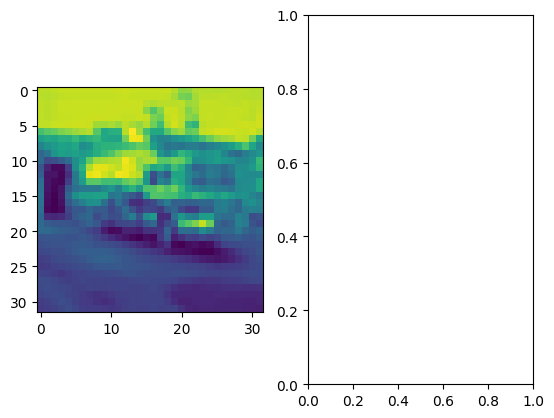

In [ ]:
for i in range(10):
  plt.figure()
  plt.subplot(121)
  plt.imshow(X.cpu()[i,0,:,:])
  plt.subplot(122)
  plt.imshow(Xhat.detach().cpu()[i,0,:,:])